# Iphone XS/XSMAX Reactions Analysis

## 1) Project Context

Its main goal is to analyse data from social networks in order to make conclusions about a certain subject.

## 2) Project Subject

We chose to work on the latest Iphone from Apple which is Iphone XS/XSMAX.
This subject can be very interesting by the fact that this product is generating tons of data in the social networks. In fact, we can identify in our research the best influencers in this field and summarize the audience thoughts about this product.

## 3) Data Collection (Web Scrapping)

- In this stage of work we will be going to scrap data from Tweeter platform using Tweepy.

In [1]:
import tweepy
import csv 
api_key = ''
api_secret = ''                 #Twitter API Credentials
access_token = ''
access_token_secret = '' 
auth = tweepy.OAuthHandler(api_key, api_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

In [2]:
search_term1 = 'iPhoneXS'
for tweet in tweepy.Cursor(api.search,q=search_term1,result_type="popular",since="2018-01-01").items(20):
    print("search_term1:",search_term1,tweet.author.name,"| retweets:",tweet.retweet_count,"| likes:",tweet.favorite_count,"|followers:",tweet.author.followers_count,"|country:",tweet.author.location,"|Verfied account?:",tweet.author.verified)
    if(tweet.retweet_count>0):
        i=0
        allretweets = []
        allretweets.extend(api.retweets(tweet.id))
        oldest = allretweets[-1].id - 1
        new_retweets=api.retweets(tweet.id)
        while len(new_retweets) > 0:
            new_retweets=api.retweets(tweet.id,max_id=oldest)
            allretweets.extend(new_retweets)
            oldest = allretweets[-1].id - 1
            print ("...%s retweet downloaded so far" % (len(allretweets)))
        outretweets = [[tweet.author.name,retweet.author.name] for retweet in allretweets]
        with open('Iphone_xs.csv', 'a', encoding='utf8', newline='') as f:
            writer = csv.writer(f)
            writer.writerows(outretweets)

- We collected the most popular 20 tweets of the moment about the new Iphone and their retweets and stored it in a file with the structure of edgelist.

## 4) Network Analysis

- Now we are going to build a graph from the data collected and analyse it.

In [3]:
import networkx as nx
import pandas as pd

df = pd.read_csv('Iphonexs.csv',names=["source","target"])
df.iloc[:,1]=df.iloc[:,1].astype(str)

from sklearn.preprocessing import LabelEncoder
df.apply(LabelEncoder().fit_transform)

g= nx.from_pandas_edgelist(df,source="source",target="target")
print(nx.info(g))
#nx.draw(g)

Ranking=pd.DataFrame(sorted(g.degree(), key=lambda x:x[1], reverse=True))
Ranking.columns = ['Author', 'Degree']
Ranking.head()

Name: 
Type: Graph
Number of nodes: 6745
Number of edges: 6963
Average degree:   2.0646


,Author,Degree
0,dbrand,1163
1,Astead,912
2,けんすう👀🚀,612
3,ギズモード・ジャパン,599
4,Marques Brownlee,583


In [4]:
import matplotlib.pyplot as plt
from community import community_louvain
sorted(nx.degree_centrality(g).items(), key=lambda x:x[1], reverse=True)[0:10]

parts = community_louvain.best_partition(g)
values = [parts.get(node) for node in g.nodes()]
spring_pos = nx.spring_layout(g)

plt.axis("off")
nx.draw_networkx(g, pos = spring_pos, cmap = plt.get_cmap("jet"), node_color = values, node_size = 35, with_labels = False)

C:\Users\ASUS\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


## 5) Sentiment Analysis

In [6]:
import json
import numpy as np
import pandas as pd
from textblob import TextBlob as tb
import matplotlib.pyplot as plt
%matplotlib inline

class SentimentAnalysis:

    def __init__(self,comments):
        self.comments = comments

    def NLP(self):
        # the total number of opinions is the sum of likes and the number of comments.
        NoOfTerms = sum([comment[1] for comment in self.comments])+len(self.comments)
        positive = 0
        wpositive = 0
        spositive = 0
        negative = 0
        wnegative = 0
        snegative = 0
        neutral = 0
        ans = []
        for comment in self.comments:
            analysis = tb(comment[0])
            if (analysis.sentiment.polarity == 0):
                neutral += comment[1]+1 #here, we suppose that people who liked the comment have the same opinion
            elif (analysis.sentiment.polarity > 0 and analysis.sentiment.polarity <= 0.3):
                wpositive += comment[1]+1
            elif (analysis.sentiment.polarity > 0.3 and analysis.sentiment.polarity <= 0.6):
                positive += comment[1]+1
            elif (analysis.sentiment.polarity > 0.6 and analysis.sentiment.polarity <= 1):
                spositive += comment[1]+1
            elif (analysis.sentiment.polarity > -0.3 and analysis.sentiment.polarity <= 0):
                wnegative += comment[1]+1
            elif (analysis.sentiment.polarity > -0.6 and analysis.sentiment.polarity <= -0.3):
                negative += comment[1]+1
            elif (analysis.sentiment.polarity > -1 and analysis.sentiment.polarity <= -0.6):
                snegative += comment[1]+1

        # finding average of how people are reacting
        ans.append(self.percentage(positive, NoOfTerms))
        ans.append(self.percentage(wpositive, NoOfTerms))
        ans.append(self.percentage(spositive, NoOfTerms))
        ans.append(self.percentage(negative, NoOfTerms))
        ans.append(self.percentage(wnegative, NoOfTerms))
        ans.append(self.percentage(snegative, NoOfTerms))
        ans.append(self.percentage(neutral, NoOfTerms))
        return ans

        
    # function to calculate percentage
    def percentage(self, part, whole):
        temp = 100 * float(part) / float(whole)
        return format(temp, '.2f')


In [8]:
iPhone = []
Not_iPhone = []
with open('iPhone.json',encoding="utf8") as f: #reading the json file
    for line in f:
        line = json.loads(line)
        s = line["text"] #access the text field of the json object
        s = s.replace(u'\ufeff','') #due to encoding issues
        s = s.replace(u'\n','') #due to encoding issues
        if("Android" in s or "android" in s): #this comment concerns the competitor
            Not_iPhone.append([s,int(line["likes"])])
        else: #this comment concerns the iPhone
            iPhone.append([s,int(line["likes"])])

In [9]:
sa1 = SentimentAnalysis(iPhone)
R1 = sa1.NLP() #contains the percentages of votes for the iPhone
sa2 = SentimentAnalysis(Not_iPhone)
R2 = sa2.NLP() #contains the percentages of votes for the competitors

R1 = [float(x) for x in R1] #convert the array to float
R2 = [float(x) for x in R2] #convert the array to float

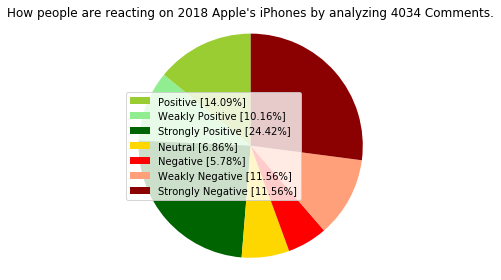

In [10]:
sizes = [R1[0]+R2[4], R1[1]+R2[5], R1[2]+R2[6], R1[3]+R2[3], R2[0]+R1[4], R2[1]+R1[5], R2[2]+R1[6]]
#we summed the strongly positive from the first array with the strongly negative from the second array, etc...
sizes = [float("{0:.2f}".format(x/2)) for x in sizes]#average of votes
labels = ['Positive [' + str(sizes[0]) + '%]', 'Weakly Positive [' + str(sizes[1]) + '%]','Strongly Positive [' + str(sizes[2]) + '%]', 'Neutral [' + str(sizes[3]) + '%]',
                  'Negative [' + str(sizes[4]) + '%]', 'Weakly Negative [' + str(sizes[5]) + '%]', 'Strongly Negative [' + str(sizes[5]) + '%]']
        
colors = ['yellowgreen','lightgreen','darkgreen', 'gold', 'red','lightsalmon','darkred']
patches, texts = plt.pie(sizes, colors=colors, startangle=90)
plt.legend(patches, labels, loc="center left")
plt.title('How people are reacting on 2018 Apple\'s iPhones by analyzing ' + str(len(iPhone)+len(Not_iPhone)) + ' Comments.')
plt.axis('equal')
plt.tight_layout()
plt.show()

At this point we have a JSON file containing comments from a review video uploaded on youtube for 2018 iPhones. Four types of comments exist :
Comments that are praising iPhones
Comments that are criticizing iPhones
Comments that are praising iPhone competitors
Comments that are criticizing iPhone competitors
The main idea is to divide the comments into two groups and interpret the NLP output for the competitors in a reversed way (every comment in favor of the competitor will be a negative comment for the iPhone and vice-versa).
For every comment, we saved its content and number of likes (to consider likes as a weight for the comment) and we appended it to the convenient list. Then, we performed NLP on the two lists.
The code above in commented in order to explain the main steps of the algorithm

- Sentiment Analysis of the video

In [11]:
with open('speech_recognition.txt') as f: #reading the json file
    data = f.read().split('.')
    
polarity = 0.0
for i in range(len(data)):
    p = tb(data[i]).polarity
    polarity = polarity + p
    
print(polarity/len(data))

0.11225701428668602


The sentiment analysis component of TextBlob indicates that the video's polarity is 0.11 which corrsponds to a weekly positive review. We can conclude that the video slightly influenced the audience overall opinion.

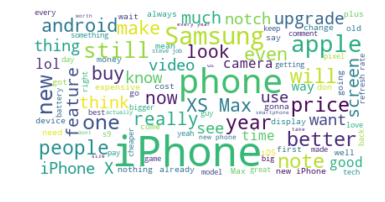

In [13]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

text = ""
for i in iPhone:
    text = text + i[0]
for i in Not_iPhone:
    text = text + i[0]
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

A wordcloud shows the most important words in a text (high presence rate).
The figure above represents a wordcloud of the youtube comments we scraped in the first step. We can observe that the most game-changers in the new iPhones are the camera and the screen, as well as the iOS operating system that is considered as the most secure mobile OS for years.
Similarly, the audience is constentely complaining about the low-capacity battery of the new phones and the notch that we find in the top of the iPhone screen. But the most important deal-breaker for the 2018's iPhones is the price.
In fact, some part of the audience is comparing those phones to the Android ones, based on the features/price ratio. Android phones have more features for a cheaper price.